Array Factor
====
Last update: 5 Oct 2018

This notebook calculates the array factor and saves the result to a file. In an antenna array, the directivity of the entire array is the multiplicative sum of the individual antenna's directivity function with a mathematical expression known as the array factor, which typically depends on the location of the elements, excitation and phase.  

In the saved data file, $\theta$ runs from $-\pi$ to $\pi$ degrees (end points are included) and $\phi$ runs from 0 to 359 degrees.  Various plots are created.  For plotting, $\theta$ and $\phi$ can run -90 to 90 or 0 to 359 depending on the plot.  

Reference:  
1) Antennas: Fundamentals, design, measurement, 3rd Ed., Lamont V. Blake  and  Maurice W. Long, 2009, ISBN: 9781891121784

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# L-Band array
From Working Group 2 meeting, the following table was presented.  Element spacing is 4.3 and 5.6 inches according to the table:  
| Frequency (MHz) | 1435 | 1480 | 1525 |
|:----------------|:----:|:----:|:----:|
| N elements | 140 | 140 | 140 |
| Dx (in) | 4.3 | 4.3 | 4.3 |
| Dy (in) | 5.6 | 5.6 | 5.6 |
|Area (sqft) | 23.2 | 23.2 | 23.2 |
| Element directivity (dBi) | 5.6 | 5.6 | 5.6 |
| Array directivity (dBi) | 28.6 | 28.8 | 29.1 |
| Estimated Beamwidth (deg) | 4.0 | 3.9 | 3.7 |

Element postions in the array lattice are in terms of $\lambda$.  

In [2]:
# array parameters
f = np.array([1435,1480,1525],dtype=float) # MHz
c = 299792458 # speed of light m/s
L = c/(f*1e6)

dx = np.array([4.3,4.3,4.3],dtype=float)
dy = np.array([5.6,5.6,5.6],dtype=float)

np.set_printoptions(precision=4)
print('free space lambda in inches for three frequencies:')
print(L*37.39)

print('dx element spacing for three frequencies in terms of lambda:')
print(dx/(L*37.39))

print('dy element spacing for three frequencies in terms of lambda:')
print(dy/(L*37.39))

free space lambda in inches for three frequencies:
[ 7.8113  7.5738  7.3503]
dx element spacing for three frequencies in terms of lambda:
[ 0.5505  0.5677  0.585 ]
dy element spacing for three frequencies in terms of lambda:
[ 0.7169  0.7394  0.7619]


## Calculate element spacing
Calculate for a hexagonal array element positions in terms of units of lambda.  Element position 0,0 is non-populated, equalateral triangles pointed left or right. Lowest frequency is used for calculating distance between points.  
$d = \lambda*0.7169$  


number of elements = 140


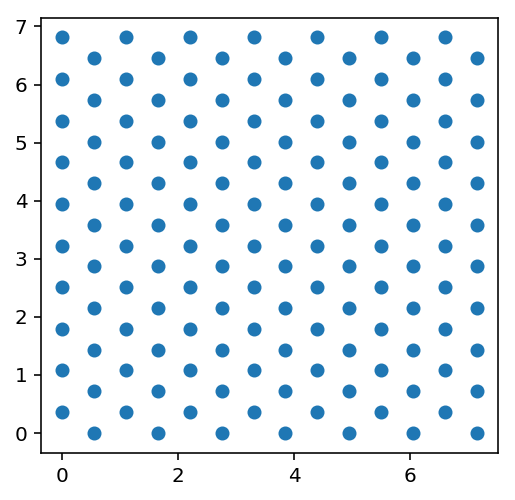

dx spacing: 0.550 lambda
dy spacing: 0.717 lambda


In [3]:
Lam = 1 # lambda (or wavelength) is 1
m = 10 # number of column elements along y axis
n = 14 # number of row elements along x axis
d = Lam*0.7169 # spacing between points
print('number of elements = {:d}'.format(m*n))

x = np.ones(m*n)
y = np.ones(m*n)

# generate coordinate points for hexagonal pattern
for j in range(n):  # rows
    for i in range(m):  # columns
        if j%2 == 0:
            y[i+m*j] = i*d + d/2
        else:
            y[i+m*j] = i*d
        x[i+m*j] = j*d*0.767  #np.sqrt(3)/2

# plot the element position in the array
plt.plot(x,y,'o')
plt.axis('image')
plt.show()

print('dx spacing: {:.3f} lambda'.format(x[10]-x[0]))
print('dy spacing: {:.3f} lambda'.format(y[1]-y[0]))

## Element weights
Set the element weights equal to 1, since design specifies side lobe levels for an unweighted array.  Center array at coordinates 0,0.  
The array excitation variable A is set to all ones.  

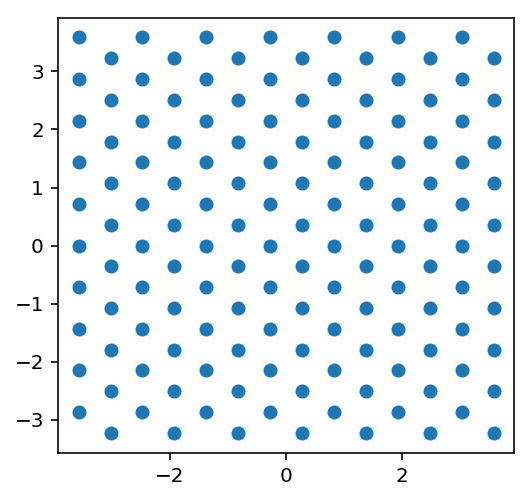

In [19]:
# set the element weights
A = np.ones(n*m) # Uniform planar excitation

# center the array in coordinate system
[x1, y1] = np.mgrid[0:m, 0:n]
x1 = (x - x[-1]/2).T
y1 = (y - y[-1]/2).T

plt.plot(x1,y1,'o')
plt.axis('image')
plt.show()

# Calculate array factor
See reference [1], pages 209 to 210

The wave number defined as the number of radians per unit distance, sometimes called the angular wavenumber.  

$k =\frac {2\pi }{\lambda }$  

For the data file, the angle $\theta$ varies from 0 to 180 degrees and the angle $\phi$ varies from 0 to 360 degrees.  Need to make sure that $\theta$ and $\phi$ run over the same angels and limits when multiplying with other data arrays.

In [20]:
Lam = 1  # all calculations are with dimensions normalized to Lambda = 1
k = 2*np.pi/Lam # wave number
print('wave number = {:.3f}'.format(k))

wave number = 6.283


In [25]:
# set scan angle
Td = 0*np.pi/180 # scan angle in theta direction
Pd = 0*np.pi/180 # scan angle in phi direction
Wnx = A*np.exp(1j*k*np.sin(Td)*np.cos(Pd)*x1)
Wny = A*np.exp(1j*k*np.sin(Td)*np.sin(Pd)*y1)

In [26]:
# make variables theta and phi and convert to radians
step = 1  # step size for various ranges
theta_min = -90
theta_max = 90
phi_min = 0
phi_max = 360
# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

AF = np.zeros((len(theta),len(phi)),dtype=complex)
for i in range(len(theta)):
    for j in range(len(phi)):
        s1 = np.sum(Wnx*np.exp(-1j*k*x1*np.sin(theta[i])*np.cos(phi[j])))
        s2 = np.sum(Wny*np.exp(-1j*k*y1*np.sin(theta[i])*np.sin(phi[j])))
        AF[i,j] = s1*s2

In [27]:
# export data file
pickle.dump(AF, open( "AF.pkl", "wb" ))

# Plot array factor

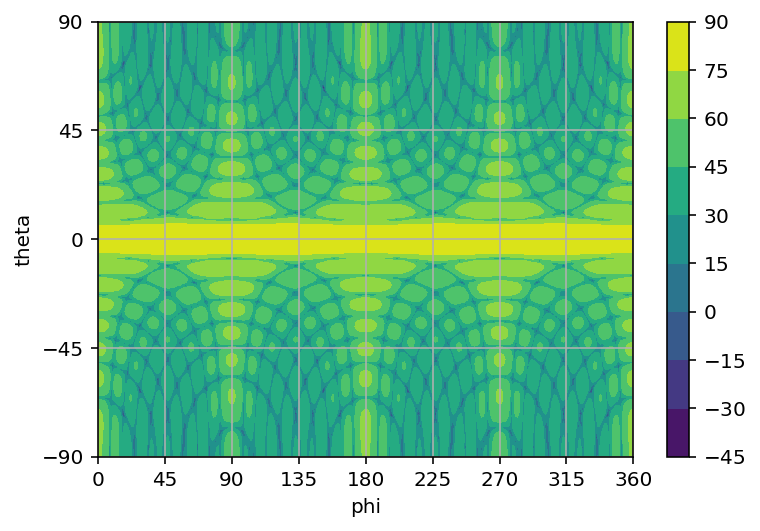

In [28]:
AF_plt = 20*np.log10(abs(AF)) # convert to dB magnitude for plotting
AF_plt  = np.clip(AF_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,AF_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

## Principle plane cuts
Plot $\theta$ from -50 to 50 to match charts from working group 2.  

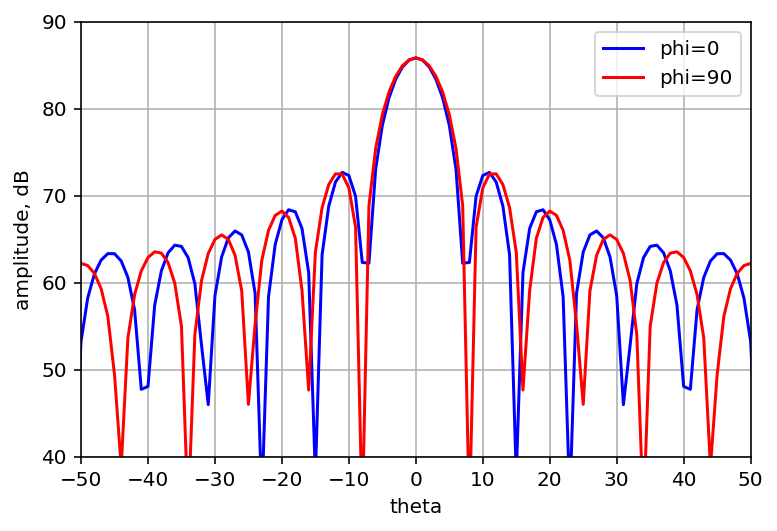

In [29]:
# phi = 0 and 90
plt.plot(theta,20*np.log10(np.absolute(AF[:,0])),'b',label='phi=0')
plt.plot(theta,20*np.log10(np.absolute(AF[:,int(90/step)])),'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(40,90)
# set plot limits
theta_min = -50
theta_max = 50
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=10))

plt.show()

In [12]:
# plot u and v,  <---- add later

## Polar plot
$\theta$ is varied from 0 to 360 degrees while leaving $\phi$ equal to 0 and 90 degrees.  

In [30]:
# make variables theta and phi and convert to radians
theta_min = 0
theta_max = 360
phi = 0

# convert deg to radians
theta = np.arange(theta_min,theta_max,step)*np.pi/180

# phi = 0
AF_phi0 = np.zeros(len(theta),dtype=complex)
for i in range(len(theta)):
    s1 = np.sum(Wnx*np.exp(-1j*k*x1*np.sin(theta[i])*np.cos(phi)))
    s2 = np.sum(Wny*np.exp(-1j*k*y1*np.sin(theta[i])*np.sin(phi)))
    AF_phi0[i] = s1*s2

# phi = 90
phi = 90*np.pi/180
AF_phi90 = np.zeros(len(theta),dtype=complex)
for i in range(len(theta)):
    s1 = np.sum(Wnx*np.exp(-1j*k*x1*np.sin(theta[i])*np.cos(phi)))
    s2 = np.sum(Wny*np.exp(-1j*k*y1*np.sin(theta[i])*np.sin(phi)))
    AF_phi90[i] = s1*s2

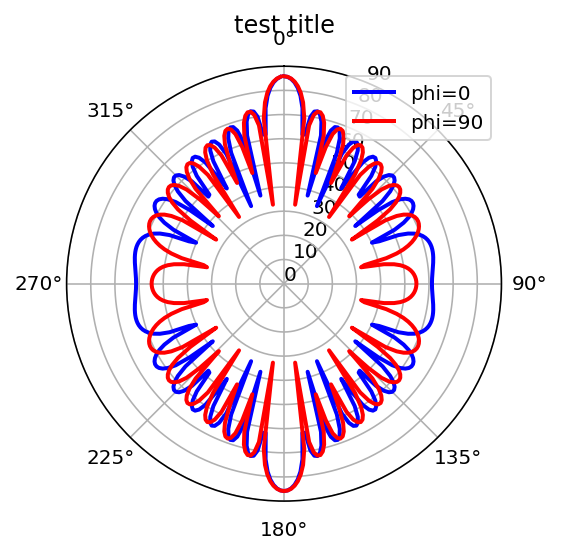

In [31]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = 0 #set plot grid
maxGrid = 100
gridSpacing = 10
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta,20*np.log10(np.absolute(AF_phi0)),'b',linewidth = 2,label='phi=0')
ax.plot(theta,20*np.log10(np.absolute(AF_phi90)),'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

# OLD CODE

In [0]:
AF.shape

# code from Matlab site
https://www.mathworks.com/matlabcentral/fileexchange/49690-array-factor-beampattern-of-discrete-array-of-any-shape  

also see:  
https://www.mathworks.com/help/antenna/analysis.html  

# extracting essential lines of code from Arraytool function pattern_uv

In [0]:
#array_ip
u_scan = 15*3.14/180 # set to +15 for a test
v_scan = 15*3.14/18
u_min = -2
u_max = 2
u_num = 300
v_min = -2
v_max = 2
v_num = 300
#scale = "dB"
dB_limit = -40
#factor= "NF"
#plot_type = "contour"
#mayavi_app = False

In [0]:
# Finally, arranging all the data into 'Arraytool' input format
x = np.reshape(x1, (M * N, -1))
y = np.reshape(y1, (M * N, -1))
z = np.zeros_like(x) # because only planar arrays are permitted here
A = np.reshape(A, (M * N, -1))
array_ip = np.hstack((x, y, z, A))  # finally, 'Arraytool' input format

In [0]:
x.shape

In [0]:
y.shape

In [0]:
z.shape

In [0]:
A.shape

In [0]:
array_ip.shape

In [0]:
x

In [0]:
x = array_ip[:, 0]
y = array_ip[:, 1]
z = array_ip[:, 2]
A = array_ip[:, 3] # un-packing "array_ip" finished

k = 2 * np.pi # (angular) wave-number, which is 2*pi when lambda = 1
u_numj = complex(0, u_num)
v_numj = complex(0, v_num)

In [0]:
A.shape

In [0]:
x.shape

In [0]:
x

In [0]:
[u, v] = np.mgrid[u_min:u_max:u_numj, v_min:v_max:v_numj]
u1 = np.reshape(u, (u.size, -1))
v1 = np.reshape(v, (v.size, -1))

A = np.reshape(A, (len(A), -1))
U = np.tile(u1 - u_scan, len(x))
V = np.tile(v1 - v_scan, len(x))
X = np.tile(x, (u.size, 1))
Y = np.tile(y, (u.size, 1))

In [0]:
u.shape

In [0]:
v.shape

In [0]:
u1.shape

In [0]:
v1.shape

In [0]:
A.shape

In [0]:
U.shape

In [0]:
V.shape

In [0]:
X.shape

In [0]:
Y.shape

# Array factor
The Array Factor is a function of the positions of the antennas in the array and the weights used.  

If the elements are identical (antenna array made up of all the same type of antennas), and have the same physical orientation (all point or face the same direction), then the radiation (or reception) pattern for an antenna array is simply the Array Factor multiplied by the radiation pattern $R(\theta,\phi)$.

In [0]:
# Evaluating array-factor of the planar array
AF1 = np.dot(np.exp(1j * k * (U * X + V * Y)), A)
AF = np.reshape(AF1, u.shape)

In [0]:
AF1.shape

In [0]:
AF.shape

In [0]:
norm_fact = (abs(A)).sum()
F = AF / norm_fact

In [0]:
norm_fact

In [0]:
F = 20 * np.log10(abs(F))
# cutoff the "F" below limit for plot
msk1 = F < dB_limit
fill = msk1 * dB_limit
msk2 = F >= dB_limit
F_plt = F * (msk2) + fill

In [0]:
F_plt.shape

In [0]:
plt.contourf(u, v, F_plt)
vs = plt.Circle((0, 0), radius=1, edgecolor='w', fill=False)
ax = plt.gca()
ax.add_patch(vs)
plt.axis('image')
plt.grid(True)
plt.xlabel(r'$u,\ \mathrm{where}\ u=\sin \theta \cos \phi\ \mathrm{in}\ \mathrm{the}\ \mathrm{visible-space}$', fontsize=16)
plt.ylabel(r'$v,\ \mathrm{where}\ v=\sin \theta \sin \phi\ \mathrm{in}\ \mathrm{the}\ \mathrm{visible-space}$', fontsize=16)
plt.colorbar(format='$%.2f$')
plt.show()

In [0]:
plt.contourf(u, v, F_plt)
#vs = plt.Circle((0, 0), radius=1, edgecolor='w', fill=False)
ax = plt.gca()
#ax.add_patch(vs)
plt.axis('image')
plt.grid(True)
#plt.xlabel(r'$u,\ \mathrm{where}\ u=\sin \theta \cos \phi\ \mathrm{in}\ \mathrm{the}\ \mathrm{visible-space}$', fontsize=16)
#plt.ylabel(r'$v,\ \mathrm{where}\ v=\sin \theta \sin \phi\ \mathrm{in}\ \mathrm{the}\ \mathrm{visible-space}$', fontsize=16)
#plt.colorbar(format='$%.2f$')
plt.show()

# Old array tool code, works